In [ ]:
pip install simpy numpy pandas matplotlib tqdm scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.3 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 23.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 18.5 MB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /Library/Developer/CommandLineTools/usr/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/1j/j11fjyg16ys35ssgq1kz8d6m0000gn/T/pip-install-juf9unls/sklearn_930398c823e1437b8d9c5fb316f7cbf0/setup.py'"'"'; __file__='"'"'/private/var/folders/1j/j11fjyg16ys35ssgq1kz8d6m0000gn/T/pip-install-juf9unls/sklearn_930398c823e1437b8d9c5fb316f7cbf0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'

Matplotlib is building the font cache; this may take a moment.
Simulation runs: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


Summary Statistics for Cloud-Based LLM Processing Service Simulation:
                          mean     std        min        max
direct_requests           6479      74       6332       6656
split_requests           25921     174      25481      26307
dropped_requests           595      40        498        710
total_requests           32400     188      32010      32794
percent_split               80       0         79         80
user_query_tokens      3563557   47046    3464816    3683875
system_query_tokens   95052192  579792   93631816   96394838
llm_response_tokens   42768946  262227   42142061   43473226
total_llm_tokens     141384694  838885  139355251  143270004
llm_cost                   424       3        418        430
aks_cost                  2290       6       2272       2307
total_cost                2714       9       2690       2737
max_nodes                   11       0         11         11
avg_nodes                    8       0          8          8


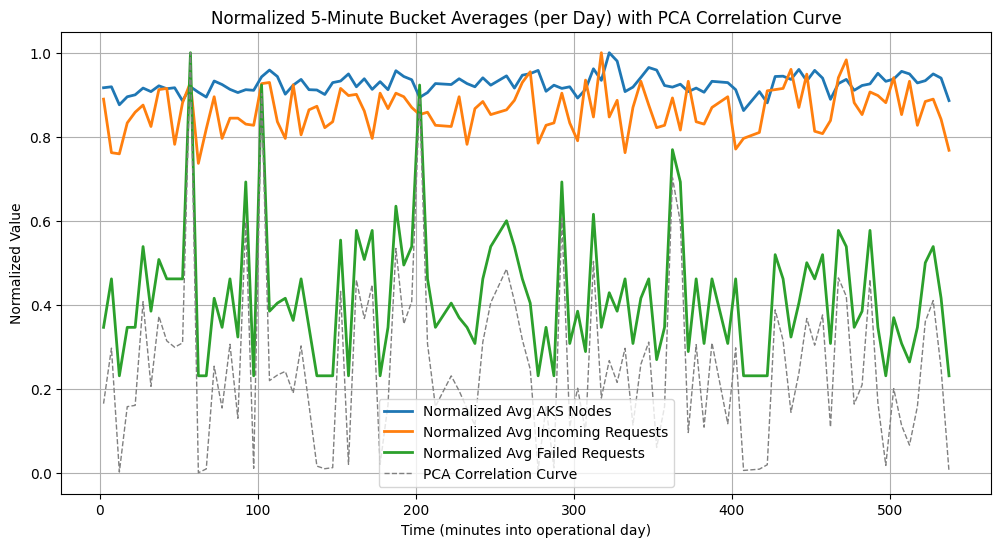

In [5]:
import simpy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -------------------------
# Constant Definitions
# -------------------------
SIM_DAYS = 30
OPERATIONAL_HOURS_PER_DAY = 9
MINUTES_PER_HOUR = 60
TOTAL_SIMULATION_MINUTES = SIM_DAYS * OPERATIONAL_HOURS_PER_DAY * MINUTES_PER_HOUR  # 30*9*60 = 16,200 minutes

REQUEST_RATE = 2  # requests per minute
MEAN_INTERARRIVAL = 1 / REQUEST_RATE  # mean interarrival time (0.5 minute)

# Node specifications
INITIAL_NODES = 7
MAX_NODES = 11  # Maximum allowed nodes
CPU_PER_NODE = 8  # vCPUs per node
RAM_PER_NODE = 32 * 1024  # MB per node (32GB)

# Cost parameters
LLM_COST_PER_MILLION_TOKENS = 3.0  # $ per million tokens
VM_COST_PER_NODE_HOUR = 0.397      # $ per node-hour
OPERATIONAL_HOURS_TOTAL = SIM_DAYS * OPERATIONAL_HOURS_PER_DAY  # 270 hours
VM_HOURS_TOTAL = SIM_DAYS * 24  # 720 hours

# Request processing probabilities and token ranges
DIRECT_PROCESSING_PROB = 0.20
SPLIT_PROCESSING_PROB = 0.80  # (implicitly, 80% split)

USER_QUERY_TOKEN_MIN, USER_QUERY_TOKEN_MAX = 100, 1000
SYSTEM_QUERY_TOKEN_MIN, SYSTEM_QUERY_TOKEN_MAX = 500, 1000
LLM_RESPONSE_TOKEN_MIN, LLM_RESPONSE_TOKEN_MAX = 100, 500
LLM_RESPONSE_TOKEN_SPIKE = 1000
LLM_RESPONSE_SPIKE_PROB = 0.03

# Processing time distribution for each agent (Poisson with mean 2 minutes, min 1 minute)
PROCESSING_TIME_MEAN = 2

# Resource consumption per agent task
CPU_PER_AGENT_MIN, CPU_PER_AGENT_MAX = 1, 2
RAM_PER_AGENT_MIN, RAM_PER_AGENT_MAX = 200, 300

# -------------------------
# Simulation Class Definition
# -------------------------
class CloudServiceSimulation:
    def __init__(self, env):
        self.env = env

        # Token counters
        self.user_query_tokens = 0
        self.system_query_tokens = 0
        self.llm_response_tokens = 0

        # Request counters
        self.direct_requests = 0
        self.split_requests = 0

        # Dropped requests counter (due to capacity limits)
        self.dropped_requests = 0

        # For per-minute time series logging
        self.request_timestamps = []      # Records the simulation time of every incoming request
        self.failed_request_timestamps = []  # Records simulation time for each dropped request

        # Current resource usage
        self.current_cpu_usage = 0.0
        self.current_ram_usage = 0.0

        # Current node count (initial cluster configuration)
        self.node_count = INITIAL_NODES

        # Lists to log node usage and resource capacity at every minute
        self.node_history = []      # List of tuples (time, node_count)
        self.resource_history = []  # List of tuples (time, cpu_usage, cpu_capacity, ram_usage, ram_capacity)

        # Start simulation processes: request generation and resource monitoring
        self.env.process(self.request_generator())
        self.env.process(self.monitor_resources())

    def available_capacity(self):
        """Return the currently available CPU and RAM capacity."""
        total_cpu_capacity = self.node_count * CPU_PER_NODE
        total_ram_capacity = self.node_count * RAM_PER_NODE
        available_cpu = total_cpu_capacity - self.current_cpu_usage
        available_ram = total_ram_capacity - self.current_ram_usage
        return available_cpu, available_ram

    def scale_up(self, additional_cpu, additional_ram):
        """Attempt to scale up if the current available capacity is insufficient.
           If scaling up beyond MAX_NODES is required, return False.
           Otherwise, return True.
        """
        available_cpu, available_ram = self.available_capacity()
        while available_cpu < additional_cpu or available_ram < additional_ram:
            if self.node_count < MAX_NODES:
                self.node_count += 1
                available_cpu, available_ram = self.available_capacity()
            else:
                return False
        return True

    def scale_down(self):
        """Scale-down: every minute, check if nodes can be removed while keeping capacity above usage.
           Remove nodes one at a time, but do not reduce below INITIAL_NODES.
        """
        if self.node_count > INITIAL_NODES:
            new_cpu_capacity = (self.node_count - 1) * CPU_PER_NODE
            new_ram_capacity = (self.node_count - 1) * RAM_PER_NODE
            if self.current_cpu_usage <= new_cpu_capacity and self.current_ram_usage <= new_ram_capacity:
                self.node_count -= 1

    def request_generator(self):
        """Generate incoming requests using exponential interarrival times until simulation end."""
        while self.env.now < TOTAL_SIMULATION_MINUTES:
            self.env.process(self.process_request())
            interarrival = np.random.exponential(MEAN_INTERARRIVAL)
            yield self.env.timeout(interarrival)

    def process_request(self):
        """Handle a new request, either using direct processing or split processing."""
        # Log the arrival time.
        self.request_timestamps.append(self.env.now)

        # Decide branch based on probability.
        if np.random.rand() < DIRECT_PROCESSING_PROB:
            self.direct_requests += 1

            # Sample tokens for the user query.
            user_tokens = np.random.randint(USER_QUERY_TOKEN_MIN, USER_QUERY_TOKEN_MAX + 1)
            if np.random.rand() < LLM_RESPONSE_SPIKE_PROB:
                response_tokens = LLM_RESPONSE_TOKEN_SPIKE
            else:
                response_tokens = np.random.randint(LLM_RESPONSE_TOKEN_MIN, LLM_RESPONSE_TOKEN_MAX + 1)

            self.user_query_tokens += user_tokens
            self.llm_response_tokens += response_tokens

            cpu_needed = np.random.uniform(CPU_PER_AGENT_MIN, CPU_PER_AGENT_MAX)
            ram_needed = np.random.uniform(RAM_PER_AGENT_MIN, RAM_PER_AGENT_MAX)
            processing_time = max(1, np.random.poisson(PROCESSING_TIME_MEAN))

            # Check if scaling up is possible without exceeding MAX_NODES.
            if not self.scale_up(cpu_needed, ram_needed):
                self.dropped_requests += 1
                self.failed_request_timestamps.append(self.env.now)
                return

            # Allocate resources.
            self.current_cpu_usage += cpu_needed
            self.current_ram_usage += ram_needed

            yield self.env.timeout(processing_time)

            # Release resources.
            self.current_cpu_usage -= cpu_needed
            self.current_ram_usage -= ram_needed

        else:
            self.split_requests += 1
            num_agents = 5

            # Pre-sample processing times, resource needs, and tokens for all agents.
            processing_times = [max(1, np.random.poisson(PROCESSING_TIME_MEAN)) for _ in range(num_agents)]
            cpu_needs = [np.random.uniform(CPU_PER_AGENT_MIN, CPU_PER_AGENT_MAX) for _ in range(num_agents)]
            ram_needs = [np.random.uniform(RAM_PER_AGENT_MIN, RAM_PER_AGENT_MAX) for _ in range(num_agents)]
            total_cpu_needed = sum(cpu_needs)
            total_ram_needed = sum(ram_needs)

            total_system_tokens_req = 0
            total_response_tokens_req = 0
            for _ in range(num_agents):
                total_system_tokens_req += np.random.randint(SYSTEM_QUERY_TOKEN_MIN, SYSTEM_QUERY_TOKEN_MAX + 1)
                if np.random.rand() < LLM_RESPONSE_SPIKE_PROB:
                    total_response_tokens_req += LLM_RESPONSE_TOKEN_SPIKE
                else:
                    total_response_tokens_req += np.random.randint(LLM_RESPONSE_TOKEN_MIN, LLM_RESPONSE_TOKEN_MAX + 1)

            # Check if we can scale up for the entire split request.
            if not self.scale_up(total_cpu_needed, total_ram_needed):
                self.dropped_requests += 1
                self.failed_request_timestamps.append(self.env.now)
                return

            # Allocate resources and update tokens.
            self.current_cpu_usage += total_cpu_needed
            self.current_ram_usage += total_ram_needed
            self.system_query_tokens += total_system_tokens_req
            self.llm_response_tokens += total_response_tokens_req

            # Create and run agent tasks concurrently.
            agent_tasks = [self.env.process(self.simple_agent_task(t)) for t in processing_times]
            yield simpy.events.AllOf(self.env, agent_tasks)

            # Release allocated resources.
            self.current_cpu_usage -= total_cpu_needed
            self.current_ram_usage -= total_ram_needed

    def simple_agent_task(self, processing_time):
        """A simple agent task that only simulates processing delay."""
        yield self.env.timeout(processing_time)

    def monitor_resources(self):
        """At every simulated minute, record resource usage and node count;
           also, attempt to scale down.
        """
        while self.env.now < TOTAL_SIMULATION_MINUTES:
            total_cpu_capacity = self.node_count * CPU_PER_NODE
            total_ram_capacity = self.node_count * RAM_PER_NODE
            self.node_history.append((self.env.now, self.node_count))
            self.resource_history.append((self.env.now, self.current_cpu_usage, total_cpu_capacity,
                                            self.current_ram_usage, total_ram_capacity))
            self.scale_down()
            yield self.env.timeout(1)

    def calculate_metrics(self):
        """Compute final metrics and costs at the end of the simulation run.
           The returned metrics are converted to integers.
        """
        total_requests = self.direct_requests + self.split_requests
        percent_split = (self.split_requests / total_requests) * 100 if total_requests > 0 else 0

        total_llm_tokens = self.user_query_tokens + self.system_query_tokens + self.llm_response_tokens
        llm_cost = (total_llm_tokens / 1_000_000) * LLM_COST_PER_MILLION_TOKENS

        node_counts = [entry[1] for entry in self.node_history]
        avg_nodes = np.mean(node_counts) if node_counts else INITIAL_NODES
        max_nodes = max(node_counts) if node_counts else INITIAL_NODES

        aks_cost = avg_nodes * VM_HOURS_TOTAL * VM_COST_PER_NODE_HOUR
        total_cost = llm_cost + aks_cost

        metrics = {
            'direct_requests': int(self.direct_requests),
            'split_requests': int(self.split_requests),
            'dropped_requests': int(self.dropped_requests),
            'total_requests': int(total_requests),
            'percent_split': int(round(percent_split)),
            'user_query_tokens': int(self.user_query_tokens),
            'system_query_tokens': int(self.system_query_tokens),
            'llm_response_tokens': int(self.llm_response_tokens),
            'total_llm_tokens': int(total_llm_tokens),
            'llm_cost': int(round(llm_cost)),
            'aks_cost': int(round(aks_cost)),
            'total_cost': int(round(total_cost)),
            'max_nodes': int(max_nodes),
            'avg_nodes': int(round(avg_nodes))
        }
        return metrics

# -------------------------
# Runner Functions
# -------------------------
def run_simulation():
    """Run a single simulation (one month of operation) and return its metrics along with the simulation instance."""
    env = simpy.Environment()
    simulation = CloudServiceSimulation(env)
    env.run(until=TOTAL_SIMULATION_MINUTES)
    metrics = simulation.calculate_metrics()
    return simulation, metrics

def run_multiple_simulations(num_runs=100):
    """Run multiple simulation runs and aggregate results using Pandas.
       Returns:
           df: DataFrame with metrics for each run.
           summary_stats: DataFrame with aggregated statistics (mean, std, min, max) for each metric.
    """
    results = []
    for _ in tqdm(range(num_runs), desc="Simulation runs"):
        _, metrics = run_simulation()
        results.append(metrics)
    df = pd.DataFrame(results)
    
    # Aggregate the results.
    summary_stats = df.agg(['mean', 'std', 'min', 'max']).transpose()
    # Round and convert all summary statistics to integers.
    summary_stats = summary_stats.round(0).astype(int)
    return df, summary_stats

# -------------------------
# Visualization Function
# -------------------------
def visualize_simulation(simulation):
    """
    Create a smooth line chart showing normalized values (0 to 1) of:
      - Average AKS nodes per 5-minute bucket across a day.
      - Average incoming requests per 5-minute bucket.
      - Average failed (dropped) requests per 5-minute bucket.
    Also overlay a thin grey dashed line representing the first principal component (PCA)
    of these three normalized curves, after min–max normalization.
    The x-axis represents the time (in minutes) into an operational day.
    """
    # For an operational day, total minutes = OPERATIONAL_HOURS_PER_DAY * MINUTES_PER_HOUR
    day_minutes = OPERATIONAL_HOURS_PER_DAY * MINUTES_PER_HOUR  # 540 minutes

    # Create DataFrame from node_history
    df_nodes = pd.DataFrame(simulation.node_history, columns=['time', 'node_count'])
    df_nodes['day'] = df_nodes['time'] // day_minutes
    df_nodes['bucket'] = (df_nodes['time'] % day_minutes) // 5
    avg_nodes = df_nodes.groupby('bucket')['node_count'].mean().reset_index()
    avg_nodes.rename(columns={'node_count':'avg_nodes'}, inplace=True)

    # Create DataFrame for incoming request timestamps
    df_requests = pd.DataFrame(simulation.request_timestamps, columns=['time'])
    df_requests['day'] = df_requests['time'] // day_minutes
    df_requests['bucket'] = (df_requests['time'] % day_minutes) // 5
    requests_group = df_requests.groupby(['day', 'bucket']).size().reset_index(name='count')
    avg_requests = requests_group.groupby('bucket')['count'].mean().reset_index()
    avg_requests.rename(columns={'count':'avg_requests'}, inplace=True)

    # Create DataFrame for failed (dropped) request timestamps
    df_failed = pd.DataFrame(simulation.failed_request_timestamps, columns=['time'])
    if not df_failed.empty:
        df_failed['day'] = df_failed['time'] // day_minutes
        df_failed['bucket'] = (df_failed['time'] % day_minutes) // 5
        failed_group = df_failed.groupby(['day', 'bucket']).size().reset_index(name='count')
        avg_failed = failed_group.groupby('bucket')['count'].mean().reset_index()
        avg_failed.rename(columns={'count':'avg_failed'}, inplace=True)
    else:
        avg_failed = pd.DataFrame({'bucket': avg_nodes['bucket'], 'avg_failed': 0})

    # Merge the averaged data
    df_avg = avg_nodes.merge(avg_requests, on='bucket').merge(avg_failed, on='bucket')
    # Compute the bucket midpoint in minutes for the x-axis.
    df_avg['time_min'] = df_avg['bucket'] * 5 + 2.5

    # Normalize each metric by its own maximum so that all curves lie in [0,1]
    df_avg['norm_nodes'] = df_avg['avg_nodes'] / df_avg['avg_nodes'].max()
    df_avg['norm_requests'] = df_avg['avg_requests'] / df_avg['avg_requests'].max()
    df_avg['norm_failed'] = df_avg['avg_failed'] / (df_avg['avg_failed'].max() if df_avg['avg_failed'].max() > 0 else 1)

    # Use PCA to derive a correlation curve from the three normalized metrics.
    X = df_avg[['norm_nodes', 'norm_requests', 'norm_failed']].values
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X).flatten()
    # Min-max normalize the first principal component to [0,1]
    pc1_norm = (pc1 - pc1.min()) / (pc1.max() - pc1.min())
    df_avg['pca_curve'] = pc1_norm

    # Plot the normalized curves and the PCA-based correlation curve.
    plt.figure(figsize=(12, 6))
    plt.plot(df_avg['time_min'], df_avg['norm_nodes'], label='Normalized Avg AKS Nodes', linewidth=2)
    plt.plot(df_avg['time_min'], df_avg['norm_requests'], label='Normalized Avg Incoming Requests', linewidth=2)
    plt.plot(df_avg['time_min'], df_avg['norm_failed'], label='Normalized Avg Failed Requests', linewidth=2)
    plt.plot(df_avg['time_min'], df_avg['pca_curve'], linestyle='--', color='grey', linewidth=1,
             label='PCA Correlation Curve')
    plt.xlabel("Time (minutes into operational day)")
    plt.ylabel("Normalized Value")
    plt.title("Normalized 5-Minute Bucket Averages (per Day) with PCA Correlation Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    # Run multiple simulation runs and output summary statistics.
    simulation_runs = 100  # Number of independent simulation runs.
    df_results, summary_stats = run_multiple_simulations(simulation_runs)

    print("Summary Statistics for Cloud-Based LLM Processing Service Simulation:")
    print(summary_stats)

    # Optionally, save results to CSV files.
    df_results.to_csv("simulation_results.csv", index=False)
    summary_stats.to_csv("simulation_summary_stats.csv")

    # Run one simulation run for visualization purposes.
    simulation_instance, _ = run_simulation()
    visualize_simulation(simulation_instance)